# Fase de pré-processamento

- Entrada: arquivo exportado pelo scraper da UOL
- Saída: Arquivo estruturado pronto para submissão ao modelo de aprendizagem

In [88]:
import sys

sys.path.append('..')

from hiperparameters.TeamStrength import *

from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

plt.style.use('seaborn')

%matplotlib inline

In [99]:
# Carga do arquivo de saída do scraper
file_src = '../output/br-league.json'

with open(file_src) as f:
    raw_data = json.load(f)

class Seasons(Enum):
    FIRST = 45
    SECOND = 90
    
def getEventsInfo(events, team, season):
    filtered = [(event["team"] == team and int(event["time"]) <= season.value) for event in events]
    return filtered.count(True)

def addTacticalType(s, data, i):
    if (s == 'OFF'):
        data["y_{}_tactical_type_off".format(i)] = 1
        data["y_{}_tactical_type_def".format(i)] = 0
        data["y_{}_tactical_type_na".format(i)] = 0
    elif (s == 'DEF'):
        data["y_{}_tactical_type_off".format(i)] = 0
        data["y_{}_tactical_type_def".format(i)] = 1
        data["y_{}_tactical_type_na".format(i)] = 0
    else:
        data["y_{}_tactical_type_off".format(i)] = 0
        data["y_{}_tactical_type_def".format(i)] = 0
        data["y_{}_tactical_type_na".format(i)] = 1

def addInterval(t, data, i):
    if (t >= 0 and t <= 15):
        data["y_{}_interval_0".format(i)] = 1
        data["y_{}_interval_1".format(i)] = 0
        data["y_{}_interval_2".format(i)] = 0
        data["y_{}_interval_3".format(i)] = 0
        data["y_{}_interval_4".format(i)] = 0
        data["y_{}_interval_5".format(i)] = 0
    elif (t > 15 and t <= 30):
        data["y_{}_interval_0".format(i)] = 0
        data["y_{}_interval_1".format(i)] = 1
        data["y_{}_interval_2".format(i)] = 0
        data["y_{}_interval_3".format(i)] = 0
        data["y_{}_interval_4".format(i)] = 0
        data["y_{}_interval_5".format(i)] = 0
    elif (t > 30 and t <= 45):
        data["y_{}_interval_0".format(i)] = 0
        data["y_{}_interval_1".format(i)] = 0
        data["y_{}_interval_2".format(i)] = 1
        data["y_{}_interval_3".format(i)] = 0
        data["y_{}_interval_4".format(i)] = 0
        data["y_{}_interval_5".format(i)] = 0
    elif (t > 45 and t <= 60):
        data["y_{}_interval_0".format(i)] = 0
        data["y_{}_interval_1".format(i)] = 0
        data["y_{}_interval_2".format(i)] = 0
        data["y_{}_interval_3".format(i)] = 1
        data["y_{}_interval_4".format(i)] = 0
        data["y_{}_interval_5".format(i)] = 0
    elif (t > 60 and t <= 75):
        data["y_{}_interval_0".format(i)] = 0
        data["y_{}_interval_1".format(i)] = 0
        data["y_{}_interval_2".format(i)] = 0
        data["y_{}_interval_3".format(i)] = 0
        data["y_{}_interval_4".format(i)] = 1
        data["y_{}_interval_5".format(i)] = 0
    elif (t > 75 and t <= 90):
        data["y_{}_interval_0".format(i)] = 0
        data["y_{}_interval_1".format(i)] = 0
        data["y_{}_interval_2".format(i)] = 0
        data["y_{}_interval_3".format(i)] = 0
        data["y_{}_interval_4".format(i)] = 0
        data["y_{}_interval_5".format(i)] = 1
        
def getYearFromDate(date):
    return date[:4]

def getSubsInfoAndLabels(data, substitutions):
    MAX_SUBSTITUTIONS = 3
    for i in range(MAX_SUBSTITUTIONS):
        try:
            data["substitution_{}_score_away".format(i)] = substitutions[i]["score_away"]
            data["substitution_{}_score_home".format(i)] = substitutions[i]["score_home"]
            data["substitution_{}_time".format(i)] = 45 if substitutions[i]["time"] == 'INTERVALO' else substitutions[i]["time"]
            data["substitution_{}_number".format(i)] = substitutions[i]["number_of_sub"]
            data["substitution_{}_is_home".format(i)] = 1 if substitutions[i]["team"] == data["home_team_name"] else 0
            addInterval(int(substitutions[i]["time"]), data, i)
            addTacticalType(substitutions[i]["tactical_type"], data, i)
            data["y_{}_effectiveness".format(i)] = substitutions[i]["effectiveness"]
        except:
            data["substitution_{}_score_away".format(i)] = 0
            data["substitution_{}_score_home".format(i)] = 0
            data["substitution_{}_time".format(i)] = 0
            data["substitution_{}_number".format(i)] = 0
            data["substitution_{}_is_home".format(i)] = 0
            data["y_{}_effectiveness".format(i)] = 0
            data["y_{}_interval_0".format(i)] = 0
            data["y_{}_interval_1".format(i)] = 0
            data["y_{}_interval_2".format(i)] = 0
            data["y_{}_interval_3".format(i)] = 0
            data["y_{}_interval_4".format(i)] = 0
            data["y_{}_interval_5".format(i)] = 0
            data["y_{}_tactical_type_off".format(i)] = 0
            data["y_{}_tactical_type_def".format(i)] = 0
            data["y_{}_tactical_type_na".format(i)] = 0

def dataFormatter(raw_data):
    output = []
    for d in raw_data:
        data = {}
        data["date"] = d["date"]
        data["home_team_name"] = d["home"]
        data["away_team_name"] = d["away"]
        data["home_win"] = d["home_win"]
        data["home_team_strength"] = TeamStrength().buildParam(d["home"], getYearFromDate(d["date"]))
        data["ycards_home_1st_season"] = getEventsInfo(d["yellowcards"],  d["home"], Seasons.FIRST)
        data["ycards_away_1st_season"] = getEventsInfo(d["yellowcards"],  d["away"], Seasons.FIRST)
        data["ycards_home_2nd_season"] = getEventsInfo(d["yellowcards"],  d["home"], Seasons.SECOND)
        data["ycards_away_2nd_season"] = getEventsInfo(d["yellowcards"],  d["away"], Seasons.SECOND)
        data["rcards_home_1st_season"] = getEventsInfo(d["redcards"],     d["home"], Seasons.FIRST)
        data["rcards_away_1st_season"] = getEventsInfo(d["redcards"],     d["away"], Seasons.FIRST)
        data["rcards_home_2nd_season"] = getEventsInfo(d["redcards"],     d["home"], Seasons.SECOND)
        data["rcards_away_2nd_season"] = getEventsInfo(d["redcards"],     d["away"], Seasons.SECOND)
        data["agoals_home_1st_season"] = getEventsInfo(d["againstgoals"], d["home"], Seasons.FIRST)
        data["agoals_away_1st_season"] = getEventsInfo(d["againstgoals"], d["away"], Seasons.FIRST)
        data["agoals_home_2nd_season"] = getEventsInfo(d["againstgoals"], d["home"], Seasons.SECOND)
        data["agoals_away_2nd_season"] = getEventsInfo(d["againstgoals"], d["away"], Seasons.SECOND)
        data["penaltys_home_1st_season"] = getEventsInfo(d["penaltys"],   d["home"], Seasons.FIRST)
        data["penaltys_away_1st_season"] = getEventsInfo(d["penaltys"],   d["away"], Seasons.FIRST)
        data["penaltys_home_2nd_season"] = getEventsInfo(d["penaltys"],   d["home"], Seasons.SECOND)
        data["penaltys_away_2nd_season"] = getEventsInfo(d["penaltys"],   d["away"], Seasons.SECOND)
        getSubsInfoAndLabels(data, d["substitutions"])
        output.append(data)
    return output
    
data = dataFormatter(raw_data)
json_stringify = json.dumps(data)
df = pd.read_json(json_stringify)

In [100]:
df.head()

,agoals_away_1st_season,agoals_away_2nd_season,agoals_home_1st_season,agoals_home_2nd_season,away_team_name,date,home_team_name,home_team_strength,home_win,penaltys_away_1st_season,...,y_2_interval_3,y_2_interval_4,y_2_interval_5,y_2_tactical_type_def,y_2_tactical_type_na,y_2_tactical_type_off,ycards_away_1st_season,ycards_away_2nd_season,ycards_home_1st_season,ycards_home_2nd_season
0,0,0,0,0,coritiba,20150509,chapecoense,0.61,1,0,...,0,1,0,1,0,0,1,2,0,2
1,0,0,0,0,vasco,20150822,goias,0.55,1,0,...,0,1,0,0,0,1,2,3,2,2
2,0,0,0,0,gremio,20151004,cruzeiro,0.69,0,0,...,0,1,0,0,1,0,1,3,1,3
3,0,0,0,0,cruzeiro,20150701,gremio,0.92,1,0,...,0,1,0,0,1,0,1,6,3,5
4,0,0,0,0,atletico-mg,20150509,palmeiras,0.79,0,0,...,0,1,0,0,1,0,2,3,1,2


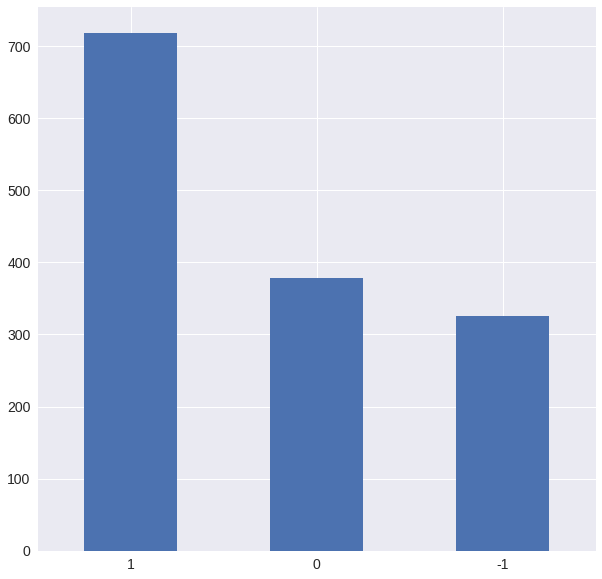

In [101]:
df["home_win"].value_counts().plot.bar(rot=0, figsize=(10,10), fontsize=14)

In [92]:
# O estudo se concentrará nos casos onde o time da casa venceu. Portanto será feito o split no dataset
# para trabalhar com os 718 casos.

df = df[df["home_win"] == 1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 0 to 1420
Data columns (total 66 columns):
agoals_away_1st_season       718 non-null int64
agoals_away_2nd_season       718 non-null int64
agoals_home_1st_season       718 non-null int64
agoals_home_2nd_season       718 non-null int64
away_team_name               718 non-null object
date                         718 non-null int64
home_team_name               718 non-null object
home_team_strength           718 non-null float64
home_win                     718 non-null int64
penaltys_away_1st_season     718 non-null int64
penaltys_away_2nd_season     718 non-null int64
penaltys_home_1st_season     718 non-null int64
penaltys_home_2nd_season     718 non-null int64
rcards_away_1st_season       718 non-null int64
rcards_away_2nd_season       718 non-null int64
rcards_home_1st_season       718 non-null int64
rcards_home_2nd_season       718 non-null int64
substitution_0_is_home       718 non-null int64
substitution_0_number     

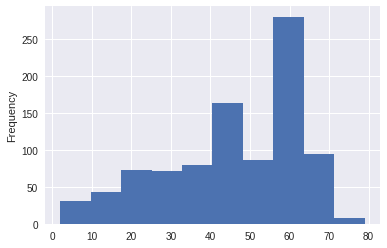

In [137]:
df_filtered = df[df["substitution_0_time"] != 0]
df_filtered["substitution_0_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

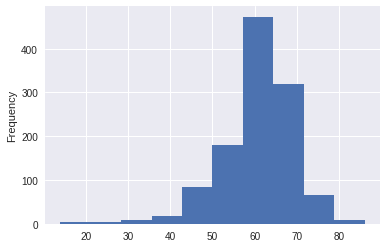

In [138]:
df_filtered = df[df["substitution_1_time"] != 0]
df_filtered["substitution_1_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

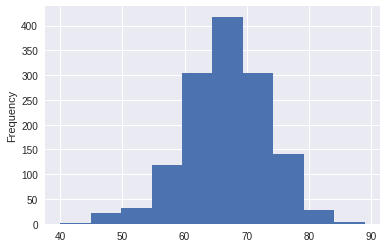

In [135]:
df_filtered = df[df["substitution_2_time"] != 0]
df_filtered["substitution_2_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

## Classificador RandomForest

In [134]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, hamming_loss

target_columns = [
   'y_0_effectiveness',
   'y_0_interval_0',
   'y_0_interval_1',
   'y_0_interval_2',
   'y_0_interval_3',
   'y_0_interval_4',
   'y_0_interval_5',
   'y_0_tactical_type_off',
   'y_0_tactical_type_def',
   'y_0_tactical_type_na',
   'y_1_effectiveness',
   'y_1_interval_0',
   'y_1_interval_1',
   'y_1_interval_2',
   'y_1_interval_3',
   'y_1_interval_4',
   'y_1_interval_5',
   'y_1_tactical_type_off',
   'y_1_tactical_type_def',
   'y_1_tactical_type_na',
   'y_2_effectiveness',
   'y_2_interval_0',
   'y_2_interval_1',
   'y_2_interval_2',
   'y_2_interval_3',
   'y_2_interval_4',
   'y_2_interval_5',
   'y_2_tactical_type_off',
   'y_2_tactical_type_def',
   'y_2_tactical_type_na',
]

Y = df.filter(target_columns, axis=1)
X = df.drop(target_columns, axis=1)
X = df.drop(['away_team_name', 'home_team_name', 'date'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

classifier = LabelPowerset(classifier=RandomForestClassifier(n_estimators=150, criterion='entropy'), require_dense = [False, True]).fit(X_train, Y_train)

y_hat = classifier.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test, y_hat))
print("Hamming: ", hamming_loss(Y_test, y_hat))

Accuracy:  0.5128805620608899
Hamming:  0.03825136612021858


## Classificador SVM

In [118]:
from sklearn.svm import SVC

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

classifier = LabelPowerset(classifier=SVC(gamma='scale'), require_dense=[False,True]).fit(X_train, Y_train)

y_hat = classifier.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test, y_hat))
print("Hamming: ", hamming_loss(Y_test, y_hat))

Accuracy:  0.117096018735363
Hamming:  0.13860699106600746


## Classificador KNN

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.problem_transform import BinaryRelevance

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

classifier = BinaryRelevance(classifier=KNeighborsClassifier(n_neighbors=3)).fit(X_train, Y_train)

y_hat = classifier.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test, y_hat))
print("Hamming: ", hamming_loss(Y_test, y_hat))

Accuracy:  0.2224824355971897
Hamming:  0.08673779165582444


## Classificador DecisionTree

In [127]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

classifier = LabelPowerset(classifier=DecisionTreeClassifier(random_state=2,criterion='entropy')).fit(X_train, Y_train)

y_hat = classifier.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test, y_hat))
print("Hamming: ", hamming_loss(Y_test, y_hat))

Accuracy:  0.4707259953161593
Hamming:  0.054879000780640126
